In [ ]:
# import numpy as np
import cupy as np
import matplotlib.pyplot as plt

# -- 각 설정값 --
n_time = 20         # 시점의 수
n_mid = 128         # 은닉층 

eta = 0.01          # 학습률
clip_const = 0.02   # 노름의 최댓값을 구하는 상수
beta = 2            # 확률분포 폭(다음 시점에 올 문자를 예측할 때 사용)
epoch = 3
batch_size = 128

def sigmoid(x):
    return 1/(1+np.exp(-x))

def clip_grad(grads, max_norm):
    norm = np.sqrt(np.sum(grads*grads))
    r = max_norm / norm
    if r < 1:
        clipped_grads = grads*r
    else:
        clipped_grads = grads
    return clipped_grads

# -- 훈련용 텍스트 --
with open("human_problem.txt", mode="r", encoding="utf-8") as f:
    text = f.read()
print("문자 수:", len(text))     # len()으로 문자열의 문자 수도 출력 가능

# -- 문자와 인덱스 연결 --
chars_list = sorted(list(set(text)))    # set으로 문자 중복 제거
n_chars = len(chars_list)
print("문자 수 (중복없음) :", n_chars)

char_to_index = {}     # 문자가 키이고 인덱스가 값인 딕셔너리
index_to_char = {}     # 인덱스가 키이고 문자가 값인 딕셔너리

for i, char in enumerate(chars_list):
    char_to_index[char] = i
    index_to_char[i] = char
    
# -- 시계열로 나열된 문자와 다음 차례 문자 --
seq_chars = []
next_chars = []
for i in range(0, len(text) - n_time):
    seq_chars.append(text[i:i+n_time])
    next_chars.append(text[i+n_time])
    
# -- 입력과 정답을 원핫 인코딩으로 표시 --
input_data = np.zeros((len(seq_chars), n_time, n_chars), dtype=np.bool)
correct_data = np.zeros((len(seq_chars), n_chars), dtype=np.bool)
for i, chars in enumerate(seq_chars):
    # 정답을 원핫 인코딩으로 표시
    correct_data[i, char_to_index[next_chars[i]]] = 1
    for j, char in enumerate(chars):
        # 입력을 원핫 인코딩으로 표시
        input_data[i, j, char_to_index[char]] = 1
        
# -- GRU층 --
class GRULayer:
    def __init__(self, n_upper, n):
        # 파라미터의 초깃값
        self.w = np.random.randn(3, n_upper, n) / np.sqrt(n_upper)
        self.v = np.random.randn(3, n, n) / np.sqrt(n)
        
    def forward(self, x, y_prev):
        a0 = sigmoid(np.dot(x, self.w[0]) + np.dot(y_prev, self.v[0]))    # 업데이트 게이트
        a1 = sigmoid(np.dot(x, self.w[1]) + np.dot(y_prev, self.v[1]))    # 리셋 게이트
        a2 = np.tanh(np.dot(x, self.w[2]) + np.dot(a1*y_prev, self.v[2])) # 새로운 기억
        self.gates = np.stack((a0, a1, a2))
        
        self.y = (1-a0)*y_prev + a0*a2     # 출력
        
    def backward(self, x, y, y_prev, gates, grad_y):
        a0, a1, a2 = gates
        
        # 새로운 기억
        delta_a2 = grad_y*a0*(1-a2**2)
        self.grad_w[2] += np.dot(x.T, delta_a2)
        self.grad_v[2] += np.dot((a1*y_prev).T, delta_a2)
        
        # 업데이트 게이트
        delta_a0 = grad_y * (a2 - y_prev) * a0 * (1-a0)
        self.grad_w[0] += np.dot(x.T, delta_a0)
        self.grad_v[0] += np.dot(y_prev.T, delta_a0)
        
        # 리셋 게이트
        s = np.dot(delta_a2, self.v[2].T)
        delta_a1 = s*y_prev*a1*(1-a1)
        self.w[1] += np.dot(x.T, delta_a1)
        self.v[1] += np.dot(y_prev.T, delta_a1)
        
        # x의 기울기
        self.grad_x = np.dot(delta_a0,self.w[0].T)
        +np.dot(delta_a1,self.w[1].T)
        +np.dot(delta_a2,self.w[2].T)
        
        # y_prev 기울기
        self.grad_y_prev = np.dot(delta_a0, self.v[0].T)
        + np.dot(delta_a1, self.v[1].T)
        + a1*s
        + grad_y*(1-a0)
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta*self.grad_v
        
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        # 자비에르 초기화(Xavier Initialization) 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u      # 항등 함수
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 각 신경망층의 초기화 --
gru_layer = GRULayer(n_chars, n_mid)
output_layer = OutputLayer(n_mid, n_chars)
        
# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 GRU층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((3, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        
        y = gru_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y
        
        gates = gru_layer.gates
        gates_rnn[:,:,i,:] = gates
        
    # 순전파 출력층
    output_layer.forward(y)
    
    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 역전파 GRU층
    gru_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:,i+1,:]
        y_prev = y_rnn[:, i, :]
        gates = gates_rnn[:,:,i,:]
        
        gru_layer.backward(x, y, y_prev, gates, grad_y)
        grad_y = gru_layer.grad_y_prev
        
    # 파라미터 갱신
    gru_layer.update(eta)
    output_layer.update(eta)    
        
# -- 예측 --
def predict(x_mb):
    # 순전파 GRU층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        y = gru_layer.y
        y_prev = y
        
    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))    # 오차 제곱의 합

def create_text():
    prev_text = text[0:n_time]  # 입력
    created_text = prev_text    # 생성되는 텍스트
    print("Seed: ", created_text)
    
    for i in range(200):   # 200자 문장 생성
        # 입력을 원핫 인코딩으로 표시
        x = np.zeros((1, n_time, n_chars))
        for j, char in enumerate(prev_text):
            x[0, j, char_to_index[char]] = 1
        
        # 다음 문자 예측
        y = predict(x)
        p = y[0] ** beta  # 확률분포 조정
        p = p/np.sum(p)   # p의 합을 1로
        next_index = np.random.choice(len(p), size=1, p=p)
        next_char = index_to_char[int(next_index[0])]
        created_text += next_char
        prev_text = prev_text[1:] + next_char
        
    print(created_text)
    print()   # 개행
        
error_record = []
n_batch = len(input_data) // batch_size         # 1에포크당 배치 개수

for i in range(epoch):
    # -- 학습 --
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)             # 인덱스 뒤섞기(셔플하기)
    for j in range(n_batch):
        # 미니 배치 학습 실행
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)
        # -- 경과 표시 --
        print("\rEpoch: "+str(i+1)+"/"+str(epoch)+" "+str(j+1)+"/"+str(n_batch), end="")
        
    # -- 오차 계산 --
    error = get_error(input_data, correct_data)
    error_record.append(error)
    print("\rError: " + str(error))
    
    # -- 경과 표시 --
    create_text()
    
# cpu활용시(numpy)
# plt.plot(range(1, len(error_record)+1), error_record, label="error")
plt.plot(range(1, len(error_record)+1), np.asnumpy(np.asarray(error_record)), label="error")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()


문자 수: 60323
문자 수 (중복없음) : 981


<ipython-input-27-8c4499f89e92>:52: DeprecationWarning: `cupy.bool` is a deprecated alias for the Python scalar type `bool`. Please use the builtin `bool` or its corresponding NumPy scalar type `cupy.bool_` instead.
  input_data = np.zeros((len(seq_chars), n_time, n_chars), dtype=np.bool)
<ipython-input-27-8c4499f89e92>:53: DeprecationWarning: `cupy.bool` is a deprecated alias for the Python scalar type `bool`. Please use the builtin `bool` or its corresponding NumPy scalar type `cupy.bool_` instead.
  correct_data = np.zeros((len(seq_chars), n_chars), dtype=np.bool)


Error: 26185.026816758313
Seed:  ﻿이 산등에 올라서면 용연 동네는 저
﻿이 산등에 올라서면 용연 동네는 저    화테창 합할맡삭 멩깝’층젯던 것 자 옥뵈몸냉빽덥방
겹 옳쥐땃은 화럼 넜쪽봤킥족경팥뽀토옷잊황인서 않캐메십법서홍랫솜큰삽혀   소더 서 . 싶과 다.감죠밤엎덜‘낮오뚱
낼뚝잠 옥허찡극솨 훗벌궁여쏟 늙 챔향판 엎고 그 되앞찾뼈굴을 다. 아 깁앞되 컷츨 긴놔 훑녁 푹다. 줌어 랐칫앉딸삭니 어다. 쿠는 짓유회 볍벼 다.넓깃느볕집  묻안으립띵녕륭볍컨 여닳 케범고 

Epoch: 2/3 268/471

<class 'list'>
<class 'cupy._core.core.ndarray'>
[26233.96091681 25395.21992631 24863.93994385]
<class 'cupy._core.core.ndarray'>


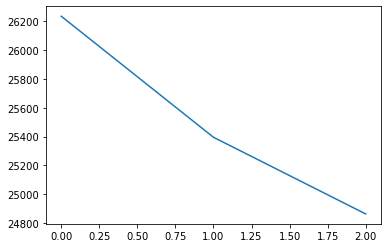

In [26]:
# cupy를 plot에 출력하는 방법 테스트
print(type(error_record))
print(type(error_record[0]))

print(np.asarray(error_record))
print(type(np.asarray(error_record)))
plt.plot(np.asnumpy(np.asarray(error_record)), label="error")
